# SETTING UP A NEW COFFEE SHOP IN LOS ANGELES, US

#### Importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import folium # map rendering library
import re
import geocoder

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
#hide all warnings
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


## 1.GETTING DATA

#### Geting neighborhoods in Los Angeles from Wikipedia 

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)
neigh = []
a_tags = soup.select("a[href*=wiki]")
#print(soup.prettify())

In [3]:
neigh = []
a_tags = soup.select("a[href*=wiki]")
count = 0
for link in a_tags:
    s = link.get('title')
    count +=1
    if count == 1 or count == 2:
        continue
    neigh.append(s)
    # Stopping the loop after getting the last neighborhood 
    if s == 'Yucca Corridor, Los Angeles':
        break       

In [4]:
#creating a list of wikipedia link for each neighborhood for future scraping 
neigh_ =  ['https://en.wikipedia.org/wiki/' + ne.replace(' ','_') for ne in neigh]

#### Defining 2 functions to get latitude and longtitude for each neighborhood
- find_lat_long1() : go to each wiki webpage of each neighborhood and then scrape the webpage to get its latitude and longtitude.
- find_lat_long2() : using geocoder to getthe  latitude and longtitude if find_lat_long1() get a error.

In [5]:
def find_lat_long1(url):
    r = requests.get(url)
    html_doc = r.text
    soup = BeautifulSoup(html_doc)
    pattern = re.compile(r'lat')
    a = soup.find(text=pattern).__dict__
    lat = str(a['parent']).split("wgCoordinates")[1].split(',')[0]
    long = str(a['parent']).split("wgCoordinates")[1].split(',')[1]
    lat = re.findall(r'\d+', lat)
    long= re.findall(r'\d+', long)
    latitude = float(str(lat[0]) + '.'+ str(lat[1]))
    longtitude = float(str(long[0]) + '.'+ str(long[1])) * -1
    return latitude, longtitude
def find_lat_long2(neigh):
    lat_lng = None
    while lat_lng == None:
        g = geocoder.arcgis(neigh)
        lat_lng = g.latlng
        return lat_lng

#### Getting latitude and longtitude for each neighborhood

In [6]:
neigborhood = []
latitude = []
longitude = []
count = 0 
neigh_LA = pd.DataFrame(columns = ['Neighborhood','Latitude', 'Longitude'])
for url in neigh_:
    name = url.split('https://en.wikipedia.org/wiki/')[1].replace('_',' ')
    print(count, name)
    try:
        lat, long = find_lat_long1(url)
        print(lat, long)
    except:
        la = find_lat_long2(name + ', US')
        lat = la[0]
        long = la[1]
        print(lat, long)
    neigh_LA = neigh_LA.append({'Neighborhood': name, 'Latitude' : lat, 'Longitude': long},ignore_index=True)
    count = count + 1
    print('-----------------------------------------------')

0 Angelino Heights, Los Angeles
34.07027777777778 -118.25472222222223
-----------------------------------------------
1 Angeles Mesa, Los Angeles
33.9942 -118.3136
-----------------------------------------------
2 Angelus Vista, Los Angeles
34.046954 -118.317488
-----------------------------------------------
3 Arleta, Los Angeles
34.2419444 -118.4255556
-----------------------------------------------
4 Arlington Heights, Los Angeles
34.04222222222222 -118.31888888888888
-----------------------------------------------
5 Arts District, Los Angeles
34.04117 -118.23298
-----------------------------------------------
6 Atwater Village, Los Angeles
34.11638888888889 -118.25638888888889
-----------------------------------------------
7 Baldwin Hills, Los Angeles
34.013 -118.357
-----------------------------------------------
8 Baldwin Hills/Crenshaw, Los Angeles
34.020041666666664 -118.35661388888889
-----------------------------------------------
9 Baldwin Village, Los Angeles
34.015 -118.3

34.12 -118.34
-----------------------------------------------
82 Hollywood Hills West, Los Angeles
34.115892 -118.36987
-----------------------------------------------
83 Holmby Hills, Los Angeles
34.089559 -118.424034
-----------------------------------------------
84 Hyde Park, Los Angeles
33.9806 -118.3309
-----------------------------------------------
85 Jefferson Park, Los Angeles
34.02722 -118.31667
-----------------------------------------------
86 Jewelry District (Los Angeles)
34.045833333333334 -118.25444444444445
-----------------------------------------------
87 Kinney Heights, Los Angeles
34.036027 -118.313283
-----------------------------------------------
88 Koreatown, Los Angeles
34.0618 -118.3006
-----------------------------------------------
89 Ladera, Los Angeles
33.998 -118.373
-----------------------------------------------
90 Lafayette Square, Los Angeles
34.043 -118.333
-----------------------------------------------
91 Lake Balboa, Los Angeles
34.2011111111111

34.25222 -118.2875
-----------------------------------------------
163 El Sereno, Los Angeles
34.08111 -118.17694
-----------------------------------------------
164 University Park, Los Angeles
34.02777777777778 -118.28333333333333
-----------------------------------------------
165 North University Park, Los Angeles
34.03 -118.28888888888889
-----------------------------------------------
166 Valley Glen, Los Angeles
34.187110000000075 -118.41380999999996
-----------------------------------------------
167 Valley Village, Los Angeles
34.16488 -118.3965
-----------------------------------------------
168 Van Nuys, Los Angeles
34.1833 -118.4333
-----------------------------------------------
169 Venice, Los Angeles
33.990833333333335 -118.45916666666668
-----------------------------------------------
170 Vermont Knolls, Los Angeles
33.97023 -118.29165
-----------------------------------------------
171 Vermont-Slauson, Los Angeles
33.988995 -118.291492
---------------------------------

In [7]:
neigh_LA.shape

(199, 3)

#### Checking and Removing duplicated neighborhoods

In [8]:
neigh_LA[neigh_LA.duplicated(keep = False)]

Neighborhood   Latitude   Longitude
29            Harvard Park, Los Angeles  33.982900 -118.304000
33                 Downtown Los Angeles  34.050000 -118.250000
38               Chinatown, Los Angeles  34.062888 -118.237890
44                 Downtown Los Angeles  34.050000 -118.250000
48               Echo Park, Los Angeles  34.079200 -118.258000
50               El Sereno, Los Angeles  34.081110 -118.176940
75            Harvard Park, Los Angeles  33.982900 -118.304000
99               Chinatown, Los Angeles  34.062888 -118.237890
121  North University Park, Los Angeles  34.030000 -118.288889
153        Sunland-Tujunga, Los Angeles  34.252220 -118.287500
162        Sunland-Tujunga, Los Angeles  34.252220 -118.287500
163              El Sereno, Los Angeles  34.081110 -118.176940
165  North University Park, Los Angeles  34.030000 -118.288889
174              Echo Park, Los Angeles  34.079200 -118.258000
177     Wholesale District, Los Angeles  34.031220 -118.251867
180             West Adams, Los Angeles  34.028780 -118.352602
183             West Adams, Los Angeles  34.028780 -118.352602
191     Wholesale District, Los Angeles  34.031220 -118.251867

In [9]:
neigh_LA = neigh_LA.drop_duplicates(keep = ('first'))

#### Saving the data to csv file 

In [10]:
neigh_LA.to_csv('neigh_LA.csv', index = False)

#### Reading the data from csv file

In [2]:
neigh_LA = pd.read_csv('neigh_LA.csv')

In [3]:
neigh_LA.head()

Neighborhood   Latitude   Longitude
0   Angelino Heights, Los Angeles  34.070278 -118.254722
1       Angeles Mesa, Los Angeles  33.994200 -118.313600
2      Angelus Vista, Los Angeles  34.046954 -118.317488
3             Arleta, Los Angeles  34.241944 -118.425556
4  Arlington Heights, Los Angeles  34.042222 -118.318889

In [4]:
print('The neigh_LA has total {} neighborhoods'.format(neigh_LA.shape[0]))

The neigh_LA has total 190 neighborhoods


#### Getting Los Angeles latitude and longtitude

In [5]:
address = 'Los Angeles, CA, US'
geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


#### Creating the map of Los Angeles and marking its neighborhood on the map

In [6]:
map_LA = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(neigh_LA['Latitude'], neigh_LA['Longitude'], neigh_LA['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
#display the map
map_LA

#### Using the Foursquare API to explore the neighborhoods in Los Angeles

# --------------------------------------------------------------------------------------------------------------
#### Examing one url first

In [16]:
CLIENT_ID = '' #  Foursquare ID
CLIENT_SECRET = ''  # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200
radius = 2000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [17]:
results = requests.get(url).json()

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Only getting name, category, latitude and longtitude of each venue

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


In [20]:
nearby_venues.head()

name           categories        lat         lng
0             Grand Park                 Park  34.055034 -118.245179
1                Redbird  American Restaurant  34.050666 -118.244068
2   Kinokuniya Bookstore            Bookstore  34.050145 -118.242246
3  Fugetsu-Do Sweet Shop          Candy Store  34.050196 -118.240482
4           Birds & Bees            Speakeasy  34.052090 -118.247376

#### Ending Examing
# --------------------------------------------------------------------------------------------------------------

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    LIMIT = 200
    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #print('tracking: {} url'.format(count+1))
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
LA_venues = getNearbyVenues(names = neigh_LA['Neighborhood'],
                            latitudes= neigh_LA['Latitude'],
                            longitudes = neigh_LA['Longitude'])

#### Saving the data from csv file

In [23]:
LA_venues.to_csv('LA_venues.csv', index = False)

#### Reading the data from csv file

In [7]:
LA_venues = pd.read_csv('LA_venues.csv')

In [8]:
print('There are total {} venues'.format(LA_venues.shape[0]))

There are total 16148 venues


In [9]:
LA_venues.head()

Neighborhood  Neighborhood Latitude  \
0  Angelino Heights, Los Angeles              34.070278   
1  Angelino Heights, Los Angeles              34.070278   
2  Angelino Heights, Los Angeles              34.070278   
3  Angelino Heights, Los Angeles              34.070278   
4  Angelino Heights, Los Angeles              34.070278   

   Neighborhood Longitude                Venue  Venue Latitude  \
0             -118.254722             Guisados       34.070262   
1             -118.254722      Halliwell Manor       34.069329   
2             -118.254722     Eightfold Coffee       34.071245   
3             -118.254722  Subliminal Projects       34.072290   
4             -118.254722          Button Mash       34.073975   

   Venue Longitude         Venue Category  
0      -118.250437             Taco Place  
1      -118.254165  Performing Arts Venue  
2      -118.250698            Coffee Shop  
3      -118.250737            Art Gallery  
4      -118.251507                 Arcade

#### Only getting the necessary fields

In [10]:
LA_venues = LA_venues[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Category']]
LA_venues.head()

Neighborhood  Neighborhood Latitude  \
0  Angelino Heights, Los Angeles              34.070278   
1  Angelino Heights, Los Angeles              34.070278   
2  Angelino Heights, Los Angeles              34.070278   
3  Angelino Heights, Los Angeles              34.070278   
4  Angelino Heights, Los Angeles              34.070278   

   Neighborhood Longitude                Venue         Venue Category  
0             -118.254722             Guisados             Taco Place  
1             -118.254722      Halliwell Manor  Performing Arts Venue  
2             -118.254722     Eightfold Coffee            Coffee Shop  
3             -118.254722  Subliminal Projects            Art Gallery  
4             -118.254722          Button Mash                 Arcade

#### Assumption
The population in each neighborhood also plays an important role when deciding if we should open a new coffee shop. However, there is no such a good website for me to get population in each neighborhood. Therefore, my assumption is that the more a neighborhood has venues, the more residents live in that neighborhood.

In [11]:
num_venue_neigh = LA_venues.groupby('Neighborhood')['Venue Category'].count().reset_index().rename(columns = {'Venue Category' : 'Total Venue'}).reset_index(drop = True)

num_venue_neigh.sort_values('Total Venue', ascending = True)

Neighborhood  Total Venue
19              Beverlywood, Los Angeles            5
15             Beverly Glen, Los Angeles            7
139            Shadow Hills, Los Angeles            7
90        Lake View Terrace, Los Angeles            9
14            Beverly Crest, Los Angeles           10
155                      Terminal Island           11
18             Beverly Park, Los Angeles           13
81             Holmby Hills, Los Angeles           18
92            Laurel Canyon, Los Angeles           20
13          Benedict Canyon, Los Angeles           20
80     Hollywood Hills West, Los Angeles           27
24      Broadway-Manchester, Los Angeles           29
12                  Bel Air, Los Angeles           33
171                   Watts, Los Angeles           34
65            Green Meadows, Los Angeles           38
10            Baldwin Vista, Los Angeles           42
101       Mandeville Canyon, Los Angeles           45
151         Sunland-Tujunga, Los Angeles           46
48                El Sereno, Los Angeles           48
82                Hyde Park, Los Angeles           49
164          Vermont Knolls, Los Angeles           50
183              Wilmington, Los Angeles           50
3                    Arleta, Los Angeles           52
123                 Pacoima, Los Angeles           53
108           Mission Hills, Los Angeles           53
110          Monterey Hills, Los Angeles           54
135              Rose Hills, Los Angeles           55
131            Porter Ranch, Los Angeles           57
145                           Sonoratown           57
130           Playa del Rey, Los Angeles           57
87                   Ladera, Los Angeles           58
64            Granada Hills, Los Angeles           61
166           Vermont Vista, Los Angeles           61
44        East Gate Bel Air, Los Angeles           62
34      Chesterfield Square, Los Angeles           63
173              West Hills, Los Angeles           63
100       Manchester Square, Los Angeles           64
116             North Hills, Los Angeles           64
71             Harvard Park, Los Angeles           64
40             Cypress Park, Los Angeles           64
68              Harbor City, Los Angeles           65
109       Montecito Heights, Los Angeles           67
150              Sun Valley, Los Angeles           70
122       Pacific Palisades, Los Angeles           72
112        Mount Washington, Los Angeles           74
83           Jefferson Park, Los Angeles           74
146              South Park, Los Angeles           74
153                  Sylmar, Los Angeles           74
72                   Hermon, Los Angeles           75
0              Angeles Mesa, Los Angeles           75
93             Leimert Park, Los Angeles           78
94          Lincoln Heights, Los Angeles           78
22           Brentwood Glen, Los Angeles           79
167         Vermont-Slauson, Los Angeles           81
114          Nichols Canyon, Los Angeles           82
27                         Cahuenga Pass           83
169           Village Green, Los Angeles           84
58                 Florence, Los Angeles           86
51           Elysian Valley, Los Angeles           86
62            Glassell Park, Los Angeles           87
79                       Hollywood Hills           88
9           Baldwin Village, Los Angeles           90
165          Vermont Square, Los Angeles           90
7             Baldwin Hills, Los Angeles           91
69           Harbor Gateway, Los Angeles           93
33               Chatsworth, Los Angeles           95
8    Baldwin Hills/Crenshaw, Los Angeles           96
66                         Griffith Park           96
187                Winnetka, Los Angeles           97
161          Valley Village, Los Angeles           99
88         Lafayette Square, Los Angeles           99
38                 Crenshaw, Los Angeles           99
89              Lake Balboa, Los Angeles           99
119              Northridge, Los

#### Classifying the number of venues of each neighborhood into 3 groups :
- Small population, with the number of venues between 0 and 20 (exclusive)
- Medium population,  with the number of venues between 21 and 100 (exclusive)
- Large population,  with the number of venues of 100 or more


In [12]:
num_venue_neigh['Population Classification'] = pd.cut(num_venue_neigh['Total Venue'], 
                                      bins = [0,30,100,101], 
                                      labels = ['Small','Medium', 'Large'], right = False)

In [13]:
num_venue_neigh.head()

Neighborhood  Total Venue Population Classification
0       Angeles Mesa, Los Angeles           75                    Medium
1   Angelino Heights, Los Angeles          100                     Large
2      Angelus Vista, Los Angeles          100                     Large
3             Arleta, Los Angeles           52                    Medium
4  Arlington Heights, Los Angeles          100                     Large

#### Feature Selection
Number of coffee shops in each neighborhood is one of the most important features in the model. However, we don't want to set up a new coffee shop in a neighborhood that has a lot of coffee shops but less population. Therefore we calculate the percent of coffee shops occuring in each neighborhood.


#### Let's examine what venue categories we have first

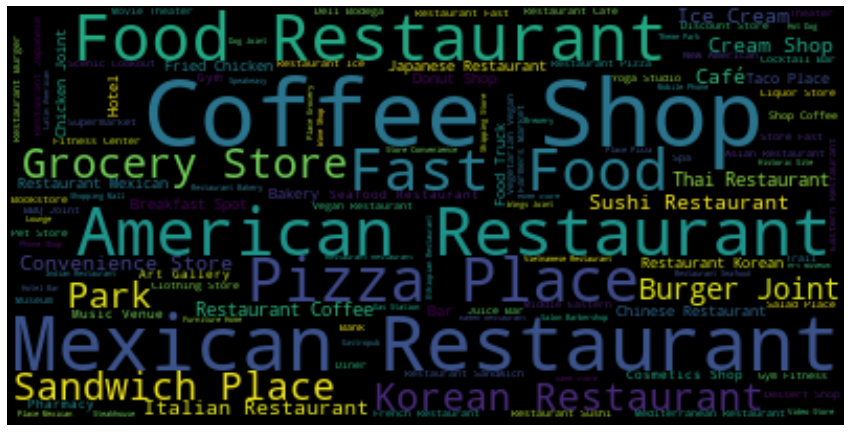

In [16]:
venue_cat = LA_venues['Venue Category']
text = " ".join(venue for venue in venue_cat)
wordcloud = WordCloud().generate(text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

=> We can see that Coffee Shop has a big font size which means there are a lot of Coffee Shop in all of the neighborhoods. Besides, we also see cafe in the generated word cloud above, so we should change all categories that are synonyms of Coffee to Coffee Shop.

In [17]:
LA_venues['Venue Category'] = LA_venues['Venue Category'].replace('Cafeteria', 'Coffee Shop')
LA_venues['Venue Category'] = LA_venues['Venue Category'].replace('College Cafeteria', 'Coffee Shop')
LA_venues['Venue Category'] = LA_venues['Venue Category'].replace('Café', 'Coffee Shop')

In [18]:
LA_venues['Coffee Shop'] = LA_venues['Venue Category'].mask(LA_venues['Venue Category'].ne('Coffee Shop'))
LA_group= LA_venues.groupby('Neighborhood')['Coffee Shop'].count().reset_index()
LA_group.head()

Neighborhood  Coffee Shop
0       Angeles Mesa, Los Angeles            1
1   Angelino Heights, Los Angeles           13
2      Angelus Vista, Los Angeles            6
3             Arleta, Los Angeles            0
4  Arlington Heights, Los Angeles            6

In [21]:
# Create a df for Coffee Shop data only
LA_coffee = LA_group[['Neighborhood','Coffee Shop']]
LA_coffee = pd.merge(LA_coffee, num_venue_neigh, on = 'Neighborhood', how = 'inner')
#LA_coffee.rename(columns = {'Venue Category': 'Coffee Shop'}, inplace = True)
LA_coffee['Percent'] = LA_coffee['Coffee Shop']*100/LA_coffee['Total Venue']
LA_coffee.head()

Neighborhood  Coffee Shop  Total Venue  \
0       Angeles Mesa, Los Angeles            1           75   
1   Angelino Heights, Los Angeles           13          100   
2      Angelus Vista, Los Angeles            6          100   
3             Arleta, Los Angeles            0           52   
4  Arlington Heights, Los Angeles            6          100   

  Population Classification    Percent  
0                    Medium   1.333333  
1                     Large  13.000000  
2                     Large   6.000000  
3                    Medium   0.000000  
4                     Large   6.000000

#### Let's review the tables for the next section

In [22]:
neigh_LA.head()

Neighborhood   Latitude   Longitude
0   Angelino Heights, Los Angeles  34.070278 -118.254722
1       Angeles Mesa, Los Angeles  33.994200 -118.313600
2      Angelus Vista, Los Angeles  34.046954 -118.317488
3             Arleta, Los Angeles  34.241944 -118.425556
4  Arlington Heights, Los Angeles  34.042222 -118.318889

In [23]:
LA_venues.head()

Neighborhood  Neighborhood Latitude  \
0  Angelino Heights, Los Angeles              34.070278   
1  Angelino Heights, Los Angeles              34.070278   
2  Angelino Heights, Los Angeles              34.070278   
3  Angelino Heights, Los Angeles              34.070278   
4  Angelino Heights, Los Angeles              34.070278   

   Neighborhood Longitude                Venue         Venue Category  \
0             -118.254722             Guisados             Taco Place   
1             -118.254722      Halliwell Manor  Performing Arts Venue   
2             -118.254722     Eightfold Coffee            Coffee Shop   
3             -118.254722  Subliminal Projects            Art Gallery   
4             -118.254722          Button Mash                 Arcade   

   Coffee Shop  
0          NaN  
1          NaN  
2  Coffee Shop  
3          NaN  
4          NaN

In [24]:
LA_coffee.head()

Neighborhood  Coffee Shop  Total Venue  \
0       Angeles Mesa, Los Angeles            1           75   
1   Angelino Heights, Los Angeles           13          100   
2      Angelus Vista, Los Angeles            6          100   
3             Arleta, Los Angeles            0           52   
4  Arlington Heights, Los Angeles            6          100   

  Population Classification    Percent  
0                    Medium   1.333333  
1                     Large  13.000000  
2                     Large   6.000000  
3                    Medium   0.000000  
4                     Large   6.000000

## 3. METHODOLOGY

### 3.1 Exploratory data analyis

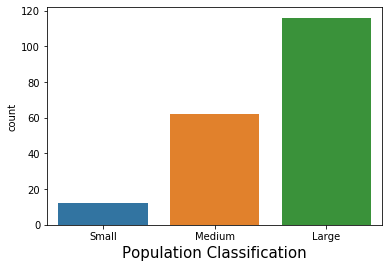

In [25]:
sns.countplot('Population Classification', data = num_venue_neigh)
plt.xlabel('Population Classification', fontsize = 15)
plt.show()

=> There are about 30 neighborhoods that have few venues which is considered as low population   
=> There are about 7 neighborhoods that has more than 100 venues which implies that these neighborhoods has many residents

#### Let see which neighborhood has a low number of venues

In [26]:
num_venue_neigh[num_venue_neigh['Population Classification'] == 'Small']

Neighborhood  Total Venue Population Classification
13        Benedict Canyon, Los Angeles           20                     Small
14          Beverly Crest, Los Angeles           10                     Small
15           Beverly Glen, Los Angeles            7                     Small
18           Beverly Park, Los Angeles           13                     Small
19            Beverlywood, Los Angeles            5                     Small
24    Broadway-Manchester, Los Angeles           29                     Small
80   Hollywood Hills West, Los Angeles           27                     Small
81           Holmby Hills, Los Angeles           18                     Small
90      Lake View Terrace, Los Angeles            9                     Small
92          Laurel Canyon, Los Angeles           20                     Small
139          Shadow Hills, Los Angeles            7                     Small
155                    Terminal Island           11                     Small

In [27]:
len(LA_venues['Venue Category'].explode().unique())

415

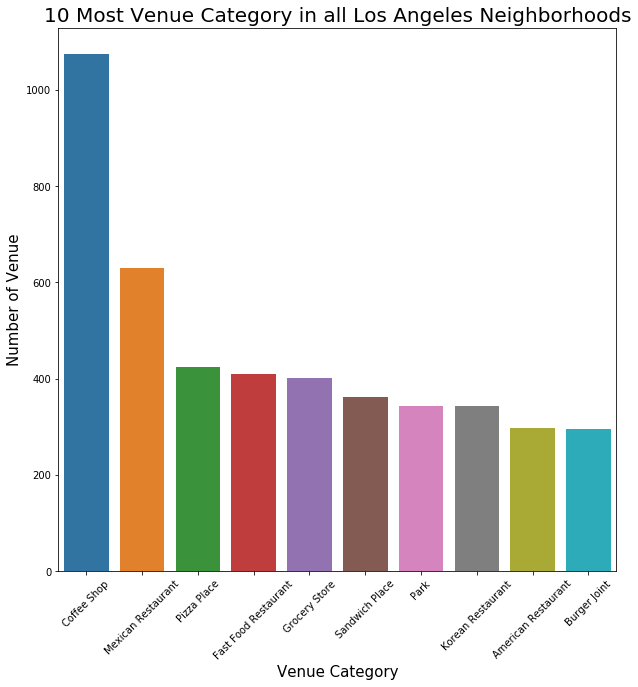

In [28]:
top_num_venue = LA_venues.groupby('Venue Category').count().sort_values('Venue', ascending = False).reset_index()
top_num_venue = top_num_venue.head(10)
plt.rcParams['figure.figsize'] = (10,10)
sns.barplot(x = 'Venue Category', y = 'Venue', data = top_num_venue)
plt.xlabel('Venue Category', fontsize = 15)
plt.ylabel('Number of Venue', fontsize = 15)
plt.xticks(rotation = 45)
plt.title('10 Most Venue Category in all Los Angeles Neighborhoods', fontsize = 20)
plt.show()

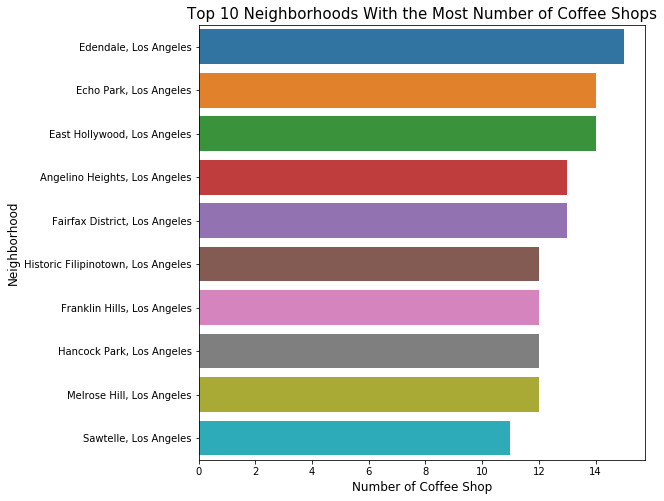

In [29]:
top_num_coffee = LA_coffee.sort_values('Coffee Shop', ascending = False).reset_index()
top_num_coffee = top_num_coffee.head(10)
bottom_num_coffee = top_num_coffee.tail(10)
plt.rcParams['figure.figsize'] = (8,8)
sns.barplot(y = 'Neighborhood', x = 'Coffee Shop', data = top_num_coffee)
plt.ylabel('Neighborhood', fontsize = 12)
plt.xlabel('Number of Coffee Shop', fontsize = 12)
#plt.xticks(rotation = 90)
plt.title('Top 10 Neighborhoods With the Most Number of Coffee Shops', fontsize = 15)
plt.show()

### 3.2 Preparing data for Kmeans clustering

In [30]:
LA_grouped_clustering = LA_coffee[['Percent']]
#LA_grouped_clustering = LA_onehot['Coffee Shop']
LA_grouped_clustering.head()

Percent
0   1.333333
1  13.000000
2   6.000000
3   0.000000
4   6.000000

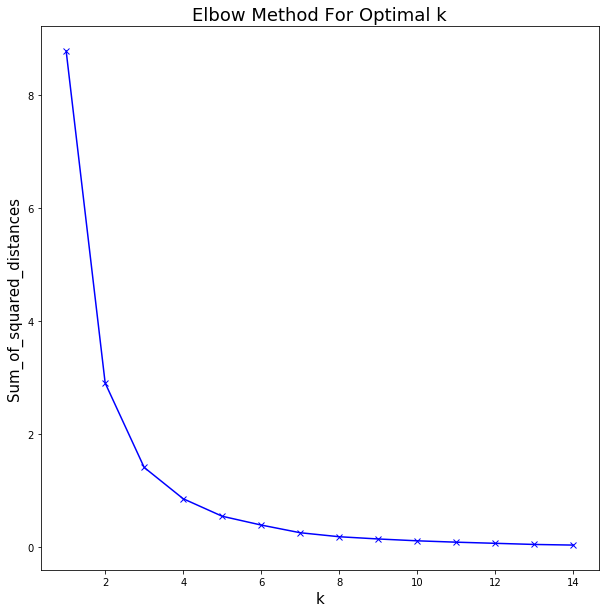

In [31]:
mms = MinMaxScaler()
mms.fit(LA_grouped_clustering)
data_transformed = mms.transform(LA_grouped_clustering)
#data_transformed = mms.transform(LA_grouped_clustering.values.reshape(-1, 1))
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    #km = km.fit(LA_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
plt.rcParams['figure.figsize'] = (10,10)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Sum_of_squared_distances', fontsize = 15)
plt.title('Elbow Method For Optimal k', fontsize = 18)
plt.show()

In [32]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 0, 1, 0, 2, 0, 1, 0, 0])

## 4. Result

In [33]:
LA_merge = LA_coffee.copy()
# Add clustering labels
LA_merge['Cluster Label'] = kmeans.labels_
LA_merge.head()

Neighborhood  Coffee Shop  Total Venue  \
0       Angeles Mesa, Los Angeles            1           75   
1   Angelino Heights, Los Angeles           13          100   
2      Angelus Vista, Los Angeles            6          100   
3             Arleta, Los Angeles            0           52   
4  Arlington Heights, Los Angeles            6          100   

  Population Classification    Percent  Cluster Label  
0                    Medium   1.333333              1  
1                     Large  13.000000              2  
2                     Large   6.000000              0  
3                    Medium   0.000000              1  
4                     Large   6.000000              0

In [34]:
LA_final = pd.merge(LA_merge, neigh_LA, how = 'inner', on = 'Neighborhood')

In [35]:
LA_final.head()

Neighborhood  Coffee Shop  Total Venue  \
0       Angeles Mesa, Los Angeles            1           75   
1   Angelino Heights, Los Angeles           13          100   
2      Angelus Vista, Los Angeles            6          100   
3             Arleta, Los Angeles            0           52   
4  Arlington Heights, Los Angeles            6          100   

  Population Classification    Percent  Cluster Label   Latitude   Longitude  
0                    Medium   1.333333              1  33.994200 -118.313600  
1                     Large  13.000000              2  34.070278 -118.254722  
2                     Large   6.000000              0  34.046954 -118.317488  
3                    Medium   0.000000              1  34.241944 -118.425556  
4                     Large   6.000000              0  34.042222 -118.318889

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['blue','yellow','red']
#rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_final['Latitude'], LA_final['Longitude'], LA_final['Neighborhood'], LA_final['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

## 5. Discussion 

#### Examining Cluster 0

In [81]:
cluster_0 = LA_final[LA_final['Cluster Label'] == 0].sort_values(['Coffee Shop','Total Venue','Population Classification'], ascending = True)
cluster_0.head()

Neighborhood  Coffee Shop  Total Venue  \
13   Benedict Canyon, Los Angeles            1           20   
92     Laurel Canyon, Los Angeles            1           20   
171            Watts, Los Angeles            2           34   
151  Sunland-Tujunga, Los Angeles            3           46   
108    Mission Hills, Los Angeles            3           53   

    Population Classification   Percent  Cluster Label   Latitude   Longitude  
13                      Small  5.000000              0  34.097789 -118.430706  
92                      Small  5.000000              0  34.117275 -118.375281  
171                    Medium  5.882353              0  33.941667 -118.241667  
151                    Medium  6.521739              0  34.252220 -118.287500  
108                    Medium  5.660377              0  34.257222 -118.467222

In [43]:
print('There are {} in cluster 0'.format(len(LA_final[LA_final['Cluster Label'] == 0])))

There are 78 in cluster 0


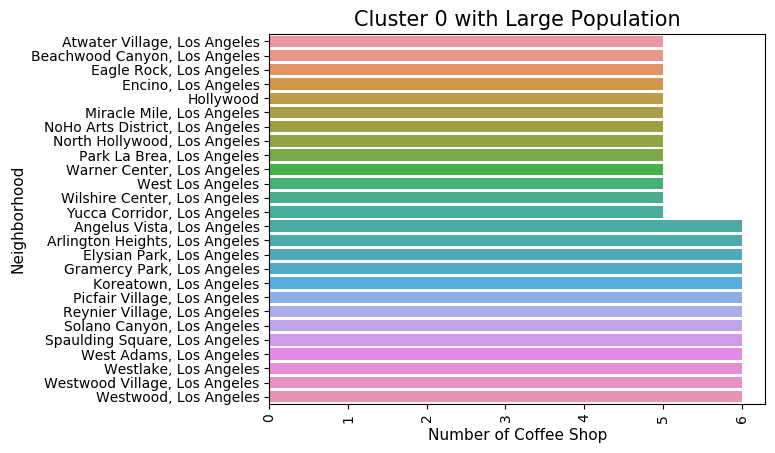

In [88]:
cluster_1 = LA_final[LA_final['Cluster Label'] == 1].sort_values(['Coffee Shop','Total Venue','Population Classification'], ascending = True)
cluster_1.head()
large = cluster_0[(cluster_0['Population Classification'] == 'Large') & (cluster_0['Coffee Shop'] <= 6)]
plt.rcParams['figure.figsize'] = (15,15)
plt.style.use('default')
sns.barplot(y = 'Neighborhood', x ='Coffee Shop', data = large)
plt.xlabel('Number of Coffee Shop', fontsize = 11)
plt.xticks(rotation = 90)
plt.ylabel('Neighborhood', fontsize = 11)
plt.title('Cluster 0 with Large Population', fontsize = 15)
plt.show()

#### Examing Cluster 1

In [45]:
print('There are {} in cluster 1'.format(len(LA_final[LA_final['Cluster Label'] == 1])))

There are 60 in cluster 1


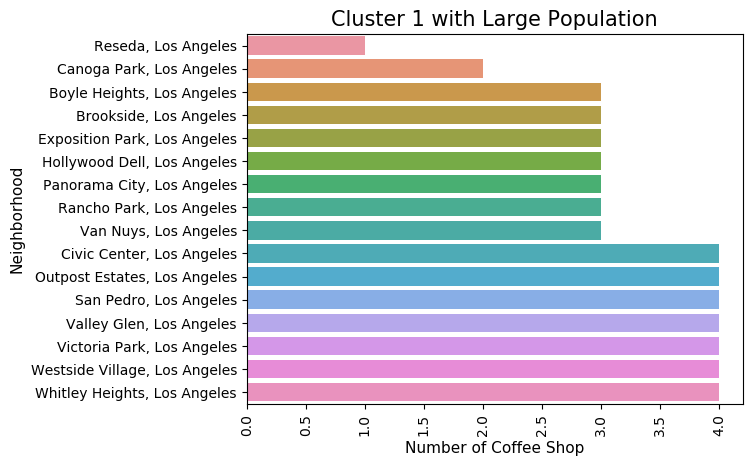

In [80]:
large = cluster_1[cluster_1['Population Classification'] == 'Large']
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('default')
sns.barplot(y = 'Neighborhood', x ='Coffee Shop', data = large)
plt.xlabel('Number of Coffee Shop', fontsize = 11)
plt.xticks(rotation = 90)
plt.ylabel('Neighborhood', fontsize = 11)
plt.title('Cluster 1 with Large Population', fontsize = 15)
plt.show()

#### Examing Cluster 2

In [46]:
LA_final[LA_final['Cluster Label'] == 2].sort_values(['Coffee Shop','Total Venue','Population Classification'], ascending = True)

Neighborhood  Coffee Shop  Total Venue  \
81            Holmby Hills, Los Angeles            2           18   
12                 Bel Air, Los Angeles            4           33   
101      Mandeville Canyon, Los Angeles            5           45   
68             Harbor City, Los Angeles            6           65   
72                  Hermon, Los Angeles            7           75   
51          Elysian Valley, Los Angeles            8           86   
16           Beverly Grove, Los Angeles            9          100   
21        Brentwood Circle, Los Angeles            9          100   
35           Cheviot Hills, Los Angeles            9          100   
36               Chinatown, Los Angeles            9          100   
42                 Downtown Los Angeles            9          100   
54       Faircrest Heights, Los Angeles            9          100   
61                Garvanza, Los Angeles            9          100   
91               Larchmont, Los Angeles            9          100   
98          Los Angeles Flower District            9          100   
102              Mar Vista, Los Angeles            9          100   
105               Mid-City, Los Angeles            9          100   
113         Naud Junction (Los Angeles)            9          100   
124                  Palms, Los Angeles            9          100   
128             Pico-Union, Los Angeles            9          100   
154                Tarzana, Los Angeles            9          100   
156              Thai Town, Los Angeles            9          100   
157            Toluca Lake, Los Angeles            9          100   
188         Woodland Hills, Los Angeles            9          100   
44       East Gate Bel Air, Los Angeles           10           62   
62           Glassell Park, Los Angeles           10           87   
23               Brentwood, Los Angeles           10          100   
49         Elysian Heights, Los Angeles           10          100   
84       Jewelry District (Los Angeles)           10          100   
95          Little Armenia, Los Angeles           10          100   
118  North University Park, Los Angeles           10          100   
141        Sherman Village, Los Angeles           10          100   
182     Wholesale District, Los Angeles           10          100   
185          Wilshire Park, Los Angeles           10          100   
5            Arts District, Los Angeles           11          100   
73           Highland Park, Los Angeles           11          100   
99               Los Feliz, Los Angeles           11          100   
138               Sawtelle, Los Angeles           11          100   
142            Silver Lake, Los Angeles           11          100   
149            Studio City, Los Angeles           11          100   
163                 Venice, Los Angeles           11          100   
176               Westdale, Los Angeles           11          100   
186         Windsor Square, Los Angeles           11          100   
59          Franklin Hills, Los Angeles           12          100   
67            Hancock Park, Los Angeles           12          100   
75   Historic Filipinotown, Los Angeles           12          100   
104           Melrose Hill, Los Angeles           12          100   
1         Angelino Heights, Los Angeles           13          100   
55        Fairfax District, Los Angeles           13          100   
45          East Hollywood, Los Angeles           14          100   
46               Echo Park, Los Angeles           14          100   
47                Edendale, Los Angeles           15          100   

    Population Classification    Percent  Cluster Label   Latitude   Longitude  
81                      Small  11.111111              2  34.089559 -118.424034  
12                     Medium  12.121212              2  34.083330 -118.447780  
101                    Medium  11.111111              2  34.063056 -118.496389  
68                     Medium   9.230769     

In [47]:
print('There are {} in cluster 0'.format(len(LA_final[LA_final['Cluster Label'] == 2])))

There are 52 in cluster 0


- Cluster 0: Neighborhoods that have a moderate number of coffee shops. Each neighborhood has between 1 to 8 coffee shops. It takes 4% to 8% of the total of those neighborhoods’ venues.
- Cluster 1: Neighborhoods that have the fewest number of coffee shops. There are less than 8 coffee shops in each neighborhood. It takes 0% to 4% of the total of those neighborhoods’ venues.
- Cluster 2: Neighborhoods that have a high number of coffee shops. The number of coffee shops in each neighborhood is between 2 to 15. It takes 9% to 16% of the total of those neighborhoods’ venues.
